# Stock Market Analysis

## Business Problem

 - A stock market investor is looking to invest in a portfolio consisting of three technology companies, three healthcare companies, as well as one cryptocurrency for the next six month period. This notebook will analyze the top ten tech and healthcare stocks according to volumne traded as well the top five cryptocurrency stocks by volume traded. The stocks will then be analyzed according to past future returns dating back to January 2016 as well as the stocks' volitility and P/E ratios over that period. A sarima model, RNN, and Facebook Prophet model will then be run on each of the stocks in order to predict future returns over the next six month period. Model results will then be compared and analyzed, and portfolio investment reccomendations will then be provided. 

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import pandas_datareader
import pandas_datareader.data as web
import datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tools.eval_measures import rmse
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
import yfinance as yf
from yahoo_fin.stock_info import get_data
import yahoo_fin.stock_info as si
import warnings
warnings.filterwarnings('ignore')

## Functions

In [2]:
def adfuller_of(series):
    """Prints the Augmented Dickey-Fuller test results."""
    
    adf, pvalue, usedlag, nobs, crit_vals, resstore = adfuller(series)
    print(f'''
                          ADF: {adf}
                      P-Value: {pvalue}
                     Used Lag: {usedlag}
       Number of Observations: {nobs}
    Critical Values (for ADF): {crit_vals}
                  ResultStore: {resstore}
    ''')

In [3]:
def get_data(stock):
    start = datetime.datetime(2016,1,1)
    end = datetime.datetime(2021,6,1)
    stock_df = web.DataReader(stock, 'yahoo', start, end)
    stock_df['Stock'] = stock
    stock_df['Returns'] = stock_df['Close'].pct_change(1)
    stock_df['Cumulative Return'] = (1 + stock_df['Returns']).cumprod()
    return stock_df

In [ ]:
def autocor(stock_df):
    monthly_df = stock_df.resample(rule='M').mean()
    plot_acf(monthly_df['Cumulative Return']);

In [ ]:
def box_plot(stock1, stock2, stock3, title1, title2, title3, graph_title):
    box_df = pd.concat([stock1['Returns'], stock2['Returns'], stock3['Returns']], axis=1)
    box_df.columns = [title1, title2, title3]
    box_df.plot(kind='box', figsize=(12,8));
    plt.title(graph_title)

In [ ]:
def returns_df(df):
    """Takes in a"""
    returns_lst = []
    for s in df.Stock.unique():
        stock_df = df[(df['Stock'] == s)]
        ret = stock_df.iloc[-1,8]
        returns_lst.append(round(ret,2)) 
        
    stock_names = []
    for n in df.Stock.unique():
        stock_names.append(n)
    
    returns_dict = dict(zip(stock_names, returns_lst))
    returns_df = pd.DataFrame(list(returns_dict.items()),columns = ['Stock','Cumulative Return']) 
    sorted_df = returns_df.sort_values(by='Cumulative Return', ascending=False).reset_index(drop=True)
    return sorted_df

In [ ]:
def plot_returns(df, title, graph_color):
    ax = df.sort_values('Cumulative Return').plot.barh(x='Stock', figsize=(12,8), color=graph_color)
    plt.title(title)
    plt.xlabel('Cumulative Return %')

In [ ]:
def get_pe_ratio(stock):
    quote_table = si.get_quote_table(stock, dict_result=False)
    return quote_table.iloc[13]

In [ ]:
def sarima_model_fcast(df, graph_title, graph_color):
    """Takes in a dataframe, runs a stepwise fit and SARIMA model on each stock and returns a dictionary of."""
    forecasted_returns = []
    for s in df.Stock.unique():
        stock_df = df[(df['Stock'] == s)]
        monthly_df = stock_df.resample(rule='M').mean()
        train = monthly_df['Cumulative Return'].iloc[:54]
        stepwise_fit = auto_arima(train)
        model_order = stepwise_fit.order
        future_model = SARIMAX(monthly_df['Cumulative Return'], order=model_order, seasonal_order=(1,1,0,7))
        results_future = future_model.fit()
        fcast = results_future.predict(len(monthly_df), len(monthly_df)+6, typ='levels').rename('SARIMA Forecast')
        fcast_df = pd.DataFrame(fcast)
        ret = fcast_df.iloc[-1,-1]
        forecasted_returns.append(round(ret,2))
        
    stock_names = []
    for n in df.Stock.unique():
        stock_names.append(n)
            
    returns_dict = dict(zip(stock_names, forecasted_returns))
    fcast_df = pd.DataFrame(list(returns_dict.items()),columns = ['Stock','Fcast Cumulative Return']) 
    ax = fcast_df.sort_values('Fcast Cumulative Return').plot.barh(x='Stock', figsize=(12,8), color=graph_color)
    plt.title(graph_title)
    plt.xlabel('Cumulative Return %')

In [ ]:
def sarima_fcast_df(df):
    forecasted_returns = []
    for s in df.Stock.unique():
        stock_df = df[(df['Stock'] == s)]
        monthly_df = stock_df.resample(rule='M').mean()
        train = monthly_df['Cumulative Return'].iloc[:54]
        stepwise_fit = auto_arima(train)
        model_order = stepwise_fit.order
        future_model = SARIMAX(monthly_df['Cumulative Return'], order=model_order, seasonal_order=(1,1,0,7))
        results_future = future_model.fit()
        fcast = results_future.predict(len(monthly_df), len(monthly_df)+6, typ='levels').rename('SARIMA Forecast')
        fcast_df = pd.DataFrame(fcast)
        ret = fcast_df.iloc[-1,-1]
        forecasted_returns.append(round(ret,2))
        
    stock_names = []
    for n in df.Stock.unique():
        stock_names.append(n)
            
    returns_dict = dict(zip(stock_names, forecasted_returns))
    fcast_df = pd.DataFrame(list(returns_dict.items()),columns = ['Stock','Fcast Cumulative Return']) 
    sorted_df = fcast_df.sort_values(by='Fcast Cumulative Return', ascending=False).reset_index(drop=True)
    return sorted_df

In [ ]:
def plot_train_pred(stock_df, graph_title):

    monthly_df = stock_df.resample(rule='M').mean()

    train = monthly_df.iloc[:54]['Cumulative Return']
    test = monthly_df.iloc[54:]['Cumulative Return']

    stepwise_fit = auto_arima(train)
    model_order = stepwise_fit.order

    model = SARIMAX(train, order=model_order, seasonal_order=(1,1,0,7))
    results = model.fit()

    train_start = train.index.min()
    train_end = train.index.max()

    predictions = results.predict(start=train_start, end=train_end, typ='levels').rename('SARIMA Predictions')

    train.plot(legend=True, figsize=(12,8))
    predictions.plot(legend=True)
    plt.ylabel('Cumulative Return %')
    plt.title(graph_title)

In [ ]:
def plot_test_pred(stock_df, graph_title):

    monthly_df = stock_df.resample(rule='M').mean()

    train = monthly_df.iloc[:54]['Cumulative Return']
    test = monthly_df.iloc[54:]['Cumulative Return']

    stepwise_fit = auto_arima(train)
    model_order = stepwise_fit.order

    model = SARIMAX(train, order=model_order, seasonal_order=(1,1,0,7))
    results = model.fit()

    test_start = test.index.min()
    test_end = test.index.max()

    test_predictions = results.predict(start=test_start, end=test_end, typ='levels').rename('SARIMA Predictions')

    test.plot(legend=True, figsize=(12,8))
    test_predictions.plot(legend=True)
    plt.ylabel('Cumulative Return %')
    plt.title(graph_title)

In [ ]:
def model_rmse(stock_df):

    resampled = stock_df.resample(rule='M').mean()

    train = resampled.iloc[:54]['Cumulative Return']
    test = resampled.iloc[54:]['Cumulative Return']

    stepwise_fit = auto_arima(train)
    model_order = stepwise_fit.order

    model = SARIMAX(train, order=model_order, seasonal_order=(1,1,0,7))
    results = model.fit()

    test_start = test.index.min()
    test_end = test.index.max()

    test_predictions = results.predict(start=test_start, end=test_end, typ='levels').rename('SARIMA Predictions')
    error = rmse(test, test_predictions)
    mean = test.mean()
    return round(error,2), round(mean,2)

In [ ]:
def plot_fcast(stock_df, graph_title):
    monthly_df = stock_df.resample(rule='M').mean()
    train = monthly_df.iloc[:54]['Cumulative Return']
    stepwise_fit = auto_arima(train)
    model_order = stepwise_fit.order
    future_model = SARIMAX(monthly_df['Cumulative Return'], order=model_order, seasonal_order=(1,1,0,7))
    results_future = future_model.fit()
    fcast = results_future.predict(len(monthly_df), len(monthly_df)+6, typ='levels').rename('SARIMA Forecast')
    conf_int = results_future.get_forecast(6)
    fcast_ci = conf_int.conf_int(alpha=0.05).rename(columns={'lower Cumulative Return':'Lower 95% Confidence Interval','upper Cumulative Return':'Upper 95% Confidence Interval'})
    fcast_ci.plot(linestyle='dotted')
    monthly_df['Cumulative Return'].plot(legend=True, figsize=(12,8))
    fcast.plot(legend=True)
    plt.ylabel('Cumulative Return %')
    plt.title(graph_title);

In [ ]:
def fb_prophet_model(df, graph_title, graph_color):
    forecasted_returns = []
    for s in df.Stock.unique():
        stock_df = df[(df['Stock'] == s)]
        returns_df = pd.DataFrame(stock_df['Cumulative Return'])
        monthly_df = returns_df.resample(rule='M').mean()
        monthly_df.reset_index(inplace=True)
        monthly_df.columns = ['ds', 'y']
        monthly_df['ds'] = pd.to_datetime(monthly_df['ds'])
        train = monthly_df[:54]
        test = monthly_df[54:]
        m = Prophet()
        m.fit(train)
        future = m.make_future_dataframe(periods=18, freq='M')
        forecast = m.predict(future)
        ret = forecast.iloc[-1,-1]
        forecasted_returns.append(round(ret,2))
        
    stock_names = []
    for n in df.Stock.unique():
        stock_names.append(n)
            
    returns_dict = dict(zip(stock_names, forecasted_returns))
    fcast_df = pd.DataFrame(list(returns_dict.items()),columns = ['Stock','Fcast Cumulative Return']) 
    ax = fcast_df.sort_values('Fcast Cumulative Return').plot.barh(x='Stock', figsize=(12,8), color=graph_color)
    plt.title(graph_title)
    plt.xlabel('Cumulative Return %')

In [ ]:
def fb_prophet_df(df):
    forecasted_returns = []
    for s in df.Stock.unique():
        stock_df = df[(df['Stock'] == s)]
        returns_df = pd.DataFrame(stock_df['Cumulative Return'])
        monthly_df = returns_df.resample(rule='M').mean()
        monthly_df.reset_index(inplace=True)
        monthly_df.columns = ['ds', 'y']
        monthly_df['ds'] = pd.to_datetime(monthly_df['ds'])
        train = monthly_df[:54]
        test = monthly_df[54:]
        m = Prophet()
        m.fit(train)
        future = m.make_future_dataframe(periods=18, freq='M')
        forecast = m.predict(future)
        ret = forecast.iloc[-1,-1]
        forecasted_returns.append(round(ret,2))
        
    stock_names = []
    for n in df.Stock.unique():
        stock_names.append(n)
            
    returns_dict = dict(zip(stock_names, forecasted_returns))
    fcast_df = pd.DataFrame(list(returns_dict.items()),columns = ['Stock','Prophet Fcast Cumulative Return']) 
    sorted_df = fcast_df.sort_values(by='Prophet Fcast Cumulative Return', ascending=False).reset_index(drop=True)
    return sorted_df

In [ ]:
def prophet_rmse(stock_df):
    stock_returns = pd.DataFrame(stock_df['Cumulative Return'])
    monthly_returns = stock_returns.resample(rule='M').mean()
    monthly_returns.reset_index(inplace=True)
    monthly_returns.columns = ['ds', 'y']
    monthly_returns['ds'] = pd.to_datetime(apple_returns_m['ds'])
    train = monthly_returns[:54]
    test = monthly_returns[54:]
    m = Prophet()
    m.fit(train)
    future = m.make_future_dataframe(periods=18, freq='M')
    forecast = m.predict(future)
    predictions = forecast.iloc[-12:]['yhat']
    return round(rmse(predictions, test['y']),2) 

In [ ]:
def plot_prophet_test_fcast(stock_df, graph_title):
    stock_returns = pd.DataFrame(stock_df['Cumulative Return'])
    monthly_returns = stock_returns.resample(rule='M').mean()
    monthly_returns.reset_index(inplace=True)
    monthly_returns.columns = ['ds', 'y']
    monthly_returns['ds'] = pd.to_datetime(apple_returns_m['ds'])
    train = monthly_returns[:54]
    test = monthly_returns[54:]
    m = Prophet()
    m.fit(train)
    future = m.make_future_dataframe(periods=18, freq='M')
    forecast = m.predict(future)
    ax = forecast.plot(x='ds', y ='yhat', label='Predictions', legend=True, figsize=(12,8))
    test.plot(x='ds', y='y', label='True Test Data', legend=True, ax=ax, xlim=('2020-07-31', '2021-12-01'))
    plt.title(graph_title)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return %');

In [ ]:
def plot_prophet_fcast(stock_df):
    stock_returns = pd.DataFrame(stock_df['Cumulative Return'])
    monthly_returns = stock_returns.resample(rule='M').mean()
    monthly_returns.reset_index(inplace=True)
    monthly_returns.columns = ['ds', 'y']
    monthly_returns['ds'] = pd.to_datetime(apple_returns_m['ds'])
    train = monthly_returns[:54]
    m = Prophet()
    m.fit(train)
    future = m.make_future_dataframe(periods=18, freq='M')
    forecast = m.predict(future)
    m.plot(forecast);

## Load Data/Data Description

### Top 10 Tech Stocks

In [4]:
apple = get_data('AAPL')

In [5]:
apple.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1362 entries, 2016-01-04 to 2021-06-01
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   High               1362 non-null   float64
 1   Low                1362 non-null   float64
 2   Open               1362 non-null   float64
 3   Close              1362 non-null   float64
 4   Volume             1362 non-null   float64
 5   Adj Close          1362 non-null   float64
 6   Stock              1362 non-null   object 
 7   Returns            1361 non-null   float64
 8   Cumulative Return  1361 non-null   float64
dtypes: float64(8), object(1)
memory usage: 106.4+ KB


In [6]:
apple.head()

,High,Low,Open,Close,Volume,Adj Close,Stock,Returns,Cumulative Return
Date,,,,,,,,,
2016-01-04,26.342501,25.500000,25.652500,26.337500,270597600.0,24.323219,AAPL,NaN,NaN
2016-01-05,26.462500,25.602501,26.437500,25.677500,223164000.0,23.713696,AAPL,-0.025059,0.974941
2016-01-06,25.592501,24.967501,25.139999,25.174999,273829600.0,23.249626,AAPL,-0.019570,0.955861
2016-01-07,25.032499,24.107500,24.670000,24.112499,324377600.0,22.268383,AAPL,-0.042205,0.915520
2016-01-08,24.777500,24.190001,24.637501,24.240000,283192000.0,22.386133,AAPL,0.005288,0.920361


In [7]:
microsoft = get_data('MSFT')

In [8]:
google = get_data('GOOG')

In [9]:
amazon = get_data('AMZN')

In [10]:
facebook = get_data('FB')

In [11]:
tencent = get_data('TCEHY')

In [12]:
alibaba = get_data('BABA')

In [13]:
tesla = get_data('TSLA')

In [14]:
tsmc = get_data('TSM')

In [15]:
nvidia = get_data('NVDA')

In [16]:
to_concat = [apple, microsoft, google, amazon, facebook, tencent, alibaba, tesla, tsmc, nvidia]
tech_df = pd.concat(to_concat)

In [17]:
tech_df.shape

(13620, 9)

In [18]:
tech_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13620 entries, 2016-01-04 to 2021-06-01
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   High               13620 non-null  float64
 1   Low                13620 non-null  float64
 2   Open               13620 non-null  float64
 3   Close              13620 non-null  float64
 4   Volume             13620 non-null  float64
 5   Adj Close          13620 non-null  float64
 6   Stock              13620 non-null  object 
 7   Returns            13610 non-null  float64
 8   Cumulative Return  13610 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.0+ MB


### Top 10 Healthcare Stocks

In [21]:
united_health = get_data('UNH')

In [22]:
cvs = get_data('CVS')

In [23]:
hca = get_data('HCA')

In [24]:
mckesson = get_data('MCK')

In [25]:
amerisource_bergen = get_data('ABC')

In [26]:
cerner = get_data('CERN')

In [27]:
teladoc_health = get_data('TDOC')

In [28]:
bio_rad = get_data('BIO')

In [29]:
cardinal_health = get_data('CAH')

In [30]:
perkin_elmer = get_data('PKI')

In [31]:
to_concat = [united_health, cvs, hca, mckesson, amerisource_bergen, cerner, teladoc_health,
            bio_rad, cardinal_health, perkin_elmer]
healthcare_df = pd.concat(to_concat)

In [32]:
healthcare_df.shape

(13620, 9)

In [33]:
healthcare_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13620 entries, 2016-01-04 to 2021-06-01
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   High               13620 non-null  float64
 1   Low                13620 non-null  float64
 2   Open               13620 non-null  float64
 3   Close              13620 non-null  float64
 4   Volume             13620 non-null  float64
 5   Adj Close          13620 non-null  float64
 6   Stock              13620 non-null  object 
 7   Returns            13610 non-null  float64
 8   Cumulative Return  13610 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.0+ MB


### Top 5 Cryptocurrency Stocks

In [34]:
bitcoin = get_data('BTC-USD')

In [35]:
ethereum = get_data('ETH-USD')

In [36]:
dogecoin = get_data('DOGE-USD')

In [37]:
xrp = get_data('XRP-USD')

In [38]:
litecoin = get_data('LTC-USD')

In [39]:
to_concat = [bitcoin, ethereum, dogecoin, xrp, litecoin]
crypto_df = pd.concat(to_concat)

In [40]:
crypto_df.shape

(9880, 9)

In [41]:
crypto_monthly = bitcoin.resample(rule='M').mean()

In [42]:
crypto_monthly.shape

(66, 8)

In [43]:
crypto_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9880 entries, 2016-01-01 to 2021-06-01
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   High               9880 non-null   float64
 1   Low                9880 non-null   float64
 2   Open               9880 non-null   float64
 3   Close              9880 non-null   float64
 4   Volume             9880 non-null   float64
 5   Adj Close          9880 non-null   float64
 6   Stock              9880 non-null   object 
 7   Returns            9875 non-null   float64
 8   Cumulative Return  9875 non-null   float64
dtypes: float64(8), object(1)
memory usage: 771.9+ KB


## Data Exploration

 - Will check the autocorrelation, decomposition, stationarity of the top stock in each industry in order to get a better feel for the data. Will also analyze the the past 5 year returns of the top stocks, as well as check the volilitilty and price to earnings ratio (P/E Ratio) of the top stocks in each sector in order to gather further information in making portfolio recommendations.  

### Autocorrelation

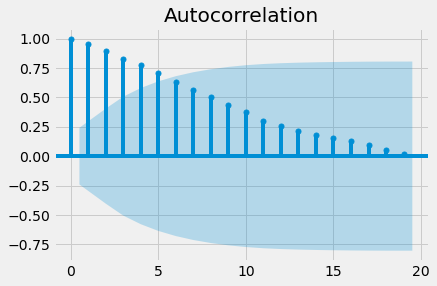

In [190]:
autocor(apple)

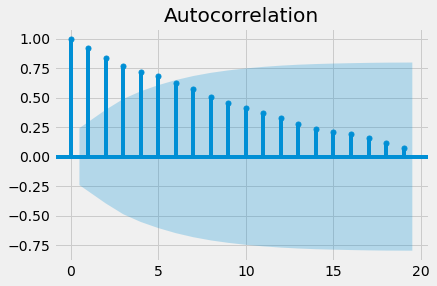

In [191]:
autocor(united_health)

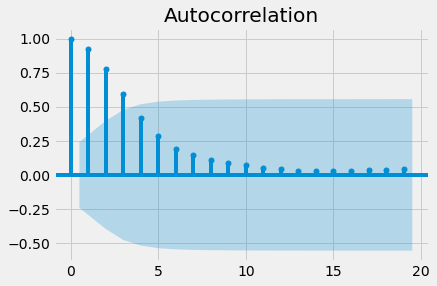

In [192]:
autocor(bitcoin)

### Decomposition

In [45]:
decomposition = seasonal_decompose(apple['Cumulative Return'].dropna(), period=365)

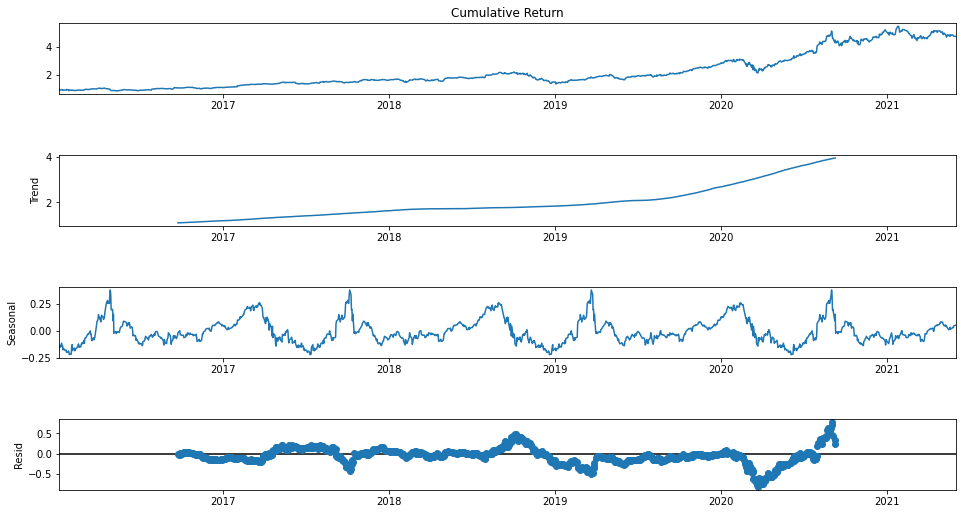

In [46]:
fig = decomposition.plot()
fig.set_size_inches(15,8)

### Dickey Fuller Test

### Rolling Mean Analysis

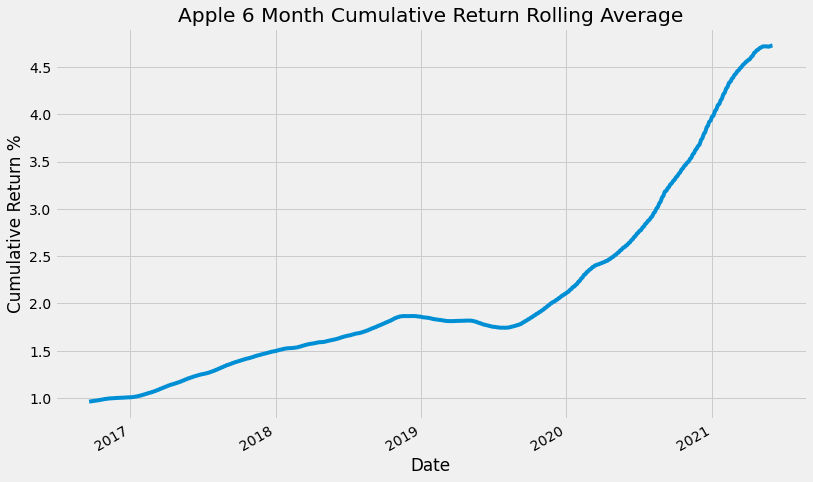

In [200]:
apple['Cumulative Return'].rolling(180).mean().plot(figsize=(12,8))
plt.title('Apple 6 Month Cumulative Return Rolling Average')
plt.ylabel('Cumulative Return %');

### Volitility Analysis

 - Will plot the returns of stocks into histograms as well as box plot to get an idea of the volitility of the stocks. The more volitile the stock, the more risky of an investment it will be over the next 6 month period. This will be taken into consideration when making portfolio recommendations.

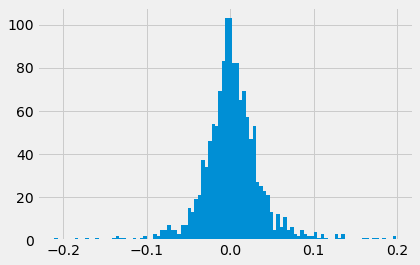

In [47]:
plt.style.use('fivethirtyeight')
tesla['Returns'].hist(bins=100);

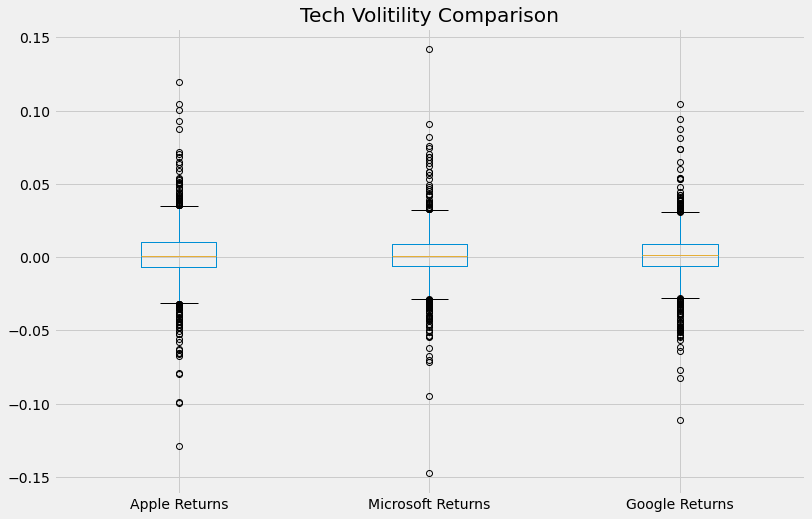

In [114]:
box_plot(apple, microsoft, google, 'Apple Returns', 'Microsoft Returns', 'Google Returns', 'Tech Volitility Comparison')

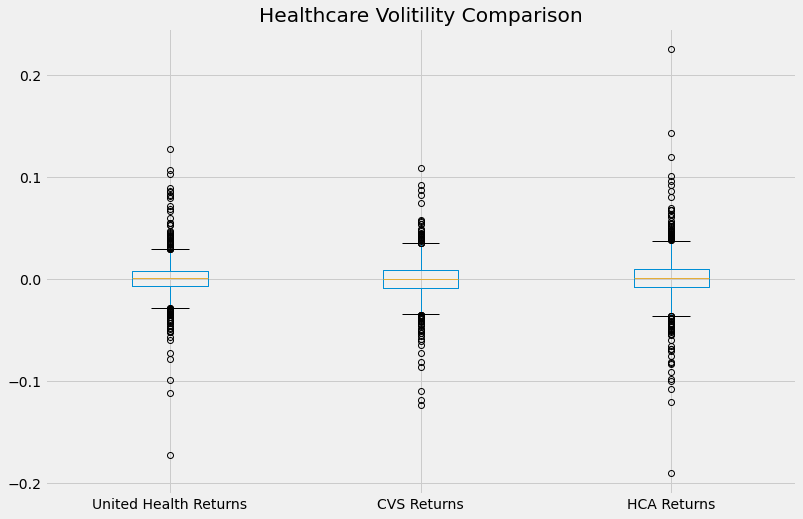

In [115]:
box_plot(united_health, cvs, hca, 'United Health Returns', 'CVS Returns', 'HCA Returns', 'Healthcare Volitility Comparison')

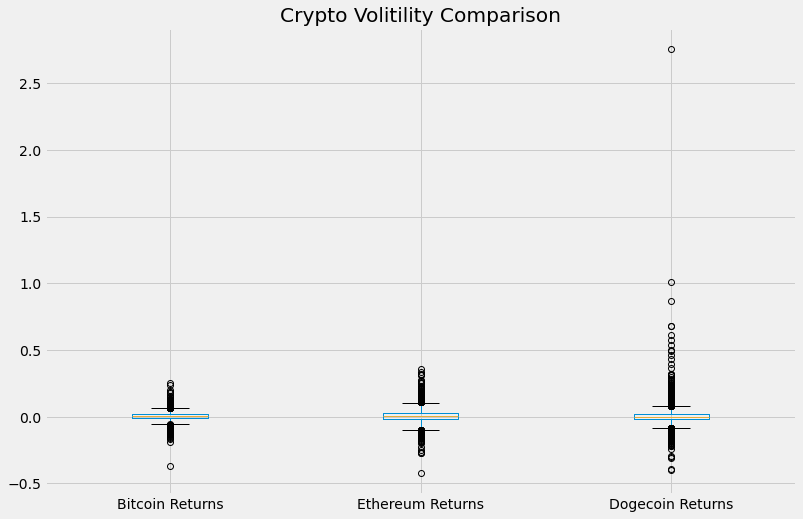

In [116]:
box_plot(bitcoin, ethereum, dogecoin, 'Bitcoin Returns', 'Ethereum Returns', 'Dogecoin Returns', 'Crypto Volitility Comparison')

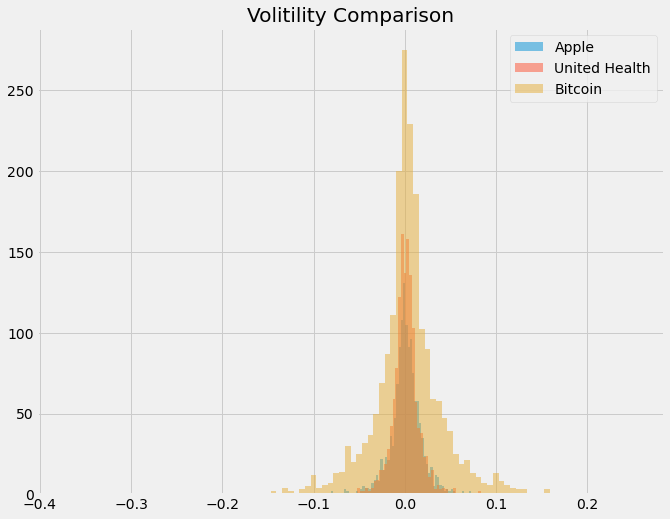

In [185]:
apple['Returns'].hist(bins=100, label='Apple', figsize=(10,8), alpha=0.5)
united_health['Returns'].hist(bins=100, label='United Health', figsize=(10,8), alpha=0.5)
bitcoin['Returns'].hist(bins=100, label='Bitcoin', figsize=(10,8), alpha=0.5)
plt.title('Volitility Comparison')
plt.legend();

### Cumulative Returns Analysis

 - Will check the cumulative returns over the past 5 year period in order to get an idea of the highest and lowest performing stocks over that time period.

In [298]:
tech_returns_df = returns_df(tech_df)
tech_returns_df

,Stock,Cumulative Return
0,NVDA,20.10
1,TSLA,13.96
2,TSM,5.36
3,AMZN,5.05
4,AAPL,4.72
5,MSFT,4.51
6,TCEHY,4.25
7,GOOG,3.28
8,FB,3.22
9,BABA,2.86


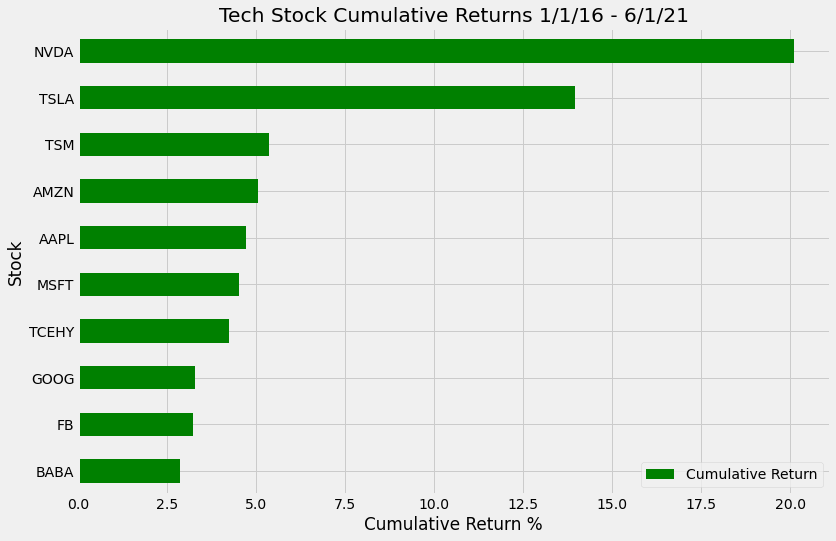

In [62]:
plot_returns(tech_returns_df, 'Tech Stock Cumulative Returns 1/1/16 - 6/1/21', 'g')

In [299]:
health_returns_df = returns_df(healthcare_df)
health_returns_df

,Stock,Cumulative Return
0,TDOC,8.47
1,BIO,4.27
2,UNH,3.49
3,HCA,3.26
4,PKI,2.70
5,CERN,1.34
6,ABC,1.12
7,MCK,0.99
8,CVS,0.89
9,CAH,0.63


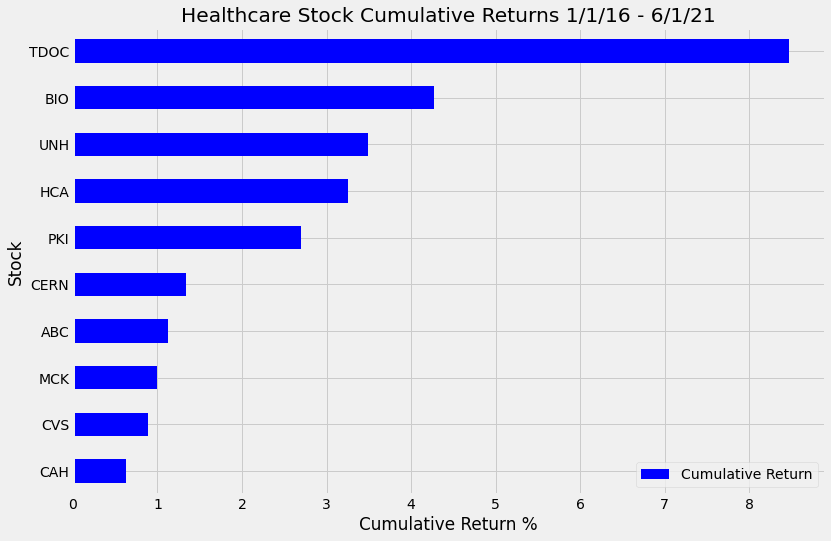

In [63]:
plot_returns(health_returns_df, 'Healthcare Stock Cumulative Returns 1/1/16 - 6/1/21', 'b')

In [300]:
crypto_returns_df = returns_df(crypto_df)
crypto_returns_df 

,Stock,Cumulative Return
0,ETH-USD,2854.49
1,DOGE-USD,2749.18
2,XRP-USD,172.02
3,BTC-USD,86.51
4,LTC-USD,53.37


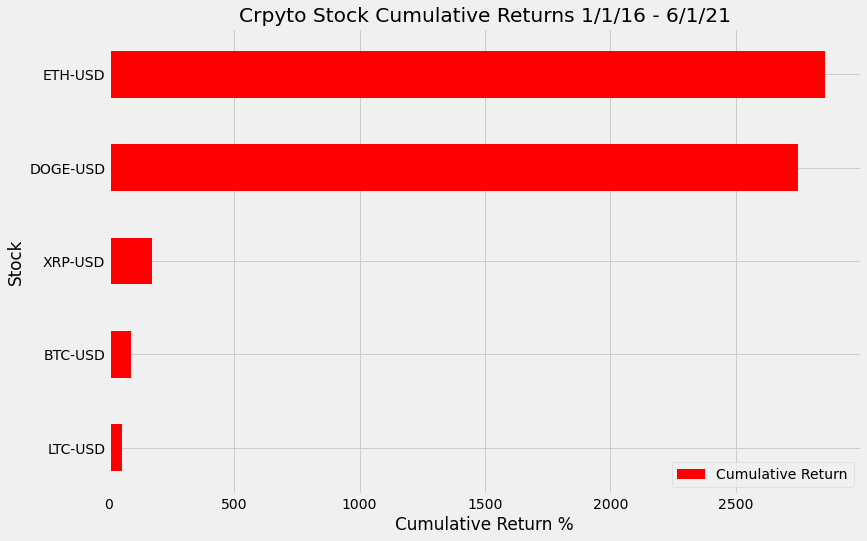

In [64]:
plot_returns(crypto_returns_df, 'Crpyto Stock Cumulative Returns 1/1/16 - 6/1/21', 'r')

In [324]:
to_concat = [tech_returns_df, health_returns_df, crypto_returns_df]
returns_comparison = pd.concat(to_concat)
returns_comparison.reset_index(drop=True, inplace=True)
returns_comparison.sort_values(by='Cumulative Return', ascending=False)

,Stock,Cumulative Return
20,ETH-USD,2854.49
21,DOGE-USD,2749.18
22,XRP-USD,172.02
23,BTC-USD,86.51
24,LTC-USD,53.37
0,NVDA,20.10
1,TSLA,13.96
10,TDOC,8.47
2,TSM,5.36
3,AMZN,5.05


### P/E Ratio Analysis

In [105]:
get_pe_ratio('AAPL')

attribute    PE Ratio (TTM)
value                 29.19
Name: 13, dtype: object

## Modeling

### SARIMA Models

In [132]:
tech_fcast = sarima_fcast_df(tech_df)
tech_fcast

,Stock,Fcast Cumulative Return
0,NVDA,25.83
1,TSLA,19.48
2,TSM,6.98
3,AMZN,5.93
4,AAPL,5.84
5,MSFT,5.43
6,TCEHY,4.86
7,GOOG,4.13
8,FB,3.73
9,BABA,3.02


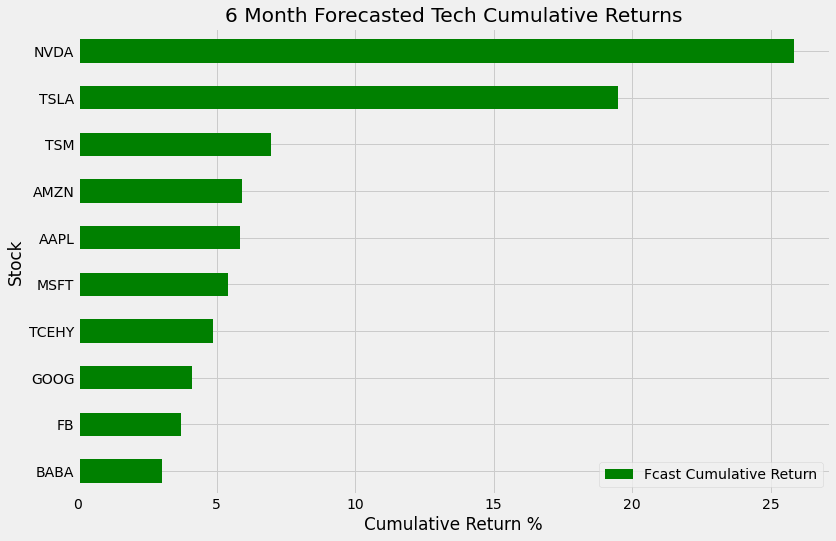

In [106]:
sarima_model_fcast(tech_df, '6 Month Forecasted Tech Cumulative Returns', 'g')

In [133]:
healthcare_fcast = sarima_fcast_df(healthcare_df)
healthcare_fcast

,Stock,Fcast Cumulative Return
0,BIO,5.17
1,HCA,4.16
2,UNH,4.01
3,PKI,3.09
4,TDOC,2.74
5,CERN,1.42
6,MCK,1.13
7,ABC,1.11
8,CVS,1.01
9,CAH,0.66


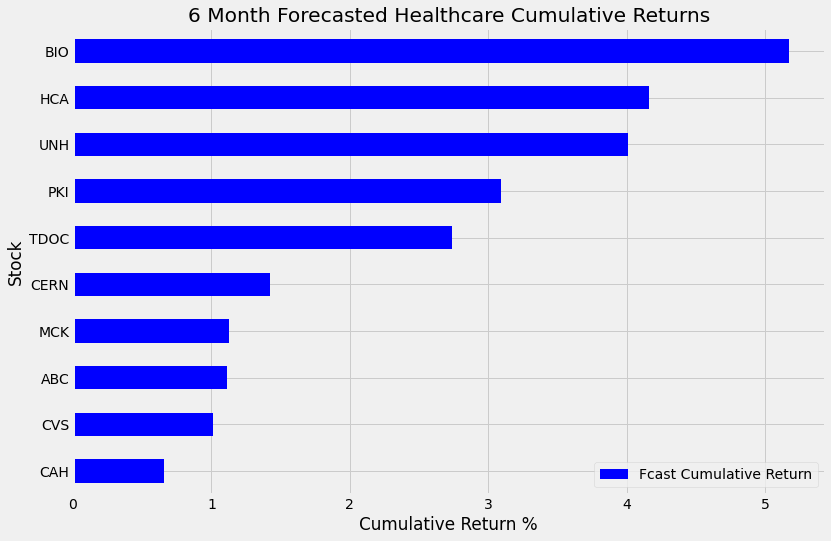

In [108]:
sarima_model_fcast(healthcare_df, '6 Month Forecasted Healthcare Cumulative Returns', 'b')

In [134]:
crypto_fcast = sarima_fcast_df(crypto_df)
crypto_fcast

,Stock,Fcast Cumulative Return
0,DOGE-USD,4534.25
1,ETH-USD,3561.64
2,XRP-USD,147.25
3,BTC-USD,122.41
4,LTC-USD,56.59


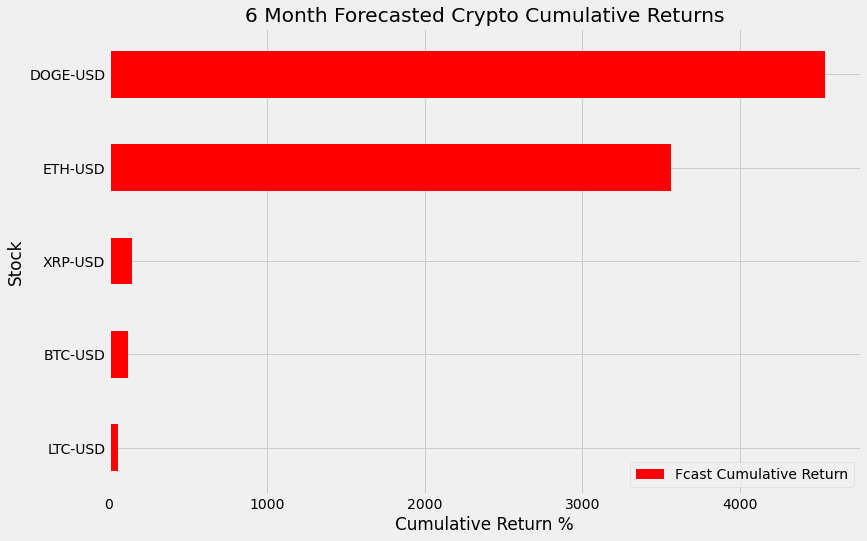

In [109]:
sarima_model_fcast(crypto_df, '6 Month Forecasted Crypto Cumulative Returns', 'r')

In [306]:
to_concat = [tech_fcast, healthcare_fcast, crypto_fcast]
fcast_comparison = pd.concat(to_concat)
fcast_comparison.reset_index(drop=True, inplace=True)
fcast_comparison

,Stock,Fcast Cumulative Return
0,NVDA,25.83
1,TSLA,19.48
2,TSM,6.98
3,AMZN,5.93
4,AAPL,5.84
5,MSFT,5.43
6,TCEHY,4.86
7,GOOG,4.13
8,FB,3.73
9,BABA,3.02


In [314]:
merged_df = returns_comparison.merge(fcast_comparison, on='Stock', how='outer')
merged_df.rename(columns = {'Cumulative Return':'Past 5 yr Cumulative Return', 'Fcast Cumulative Return':'SARIMA 6 Month Fcast'}, inplace = True)

In [315]:
merged_df.head()

,Stock,Past 5 yr Cumulative Return,SARIMA 6 Month Fcast
0,NVDA,20.10,25.83
1,TSLA,13.96,19.48
2,TSM,5.36,6.98
3,AMZN,5.05,5.93
4,AAPL,4.72,5.84


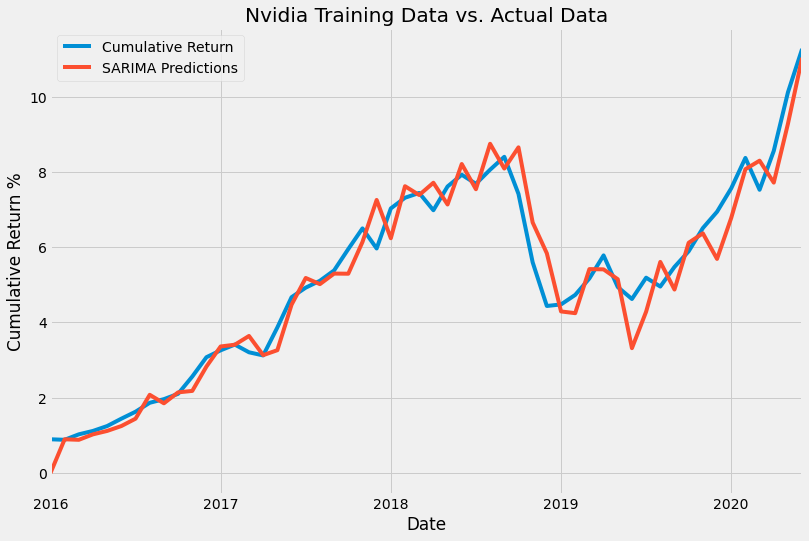

In [169]:
plot_train_pred(nvidia, 'Nvidia Training Data vs. Actual Data')

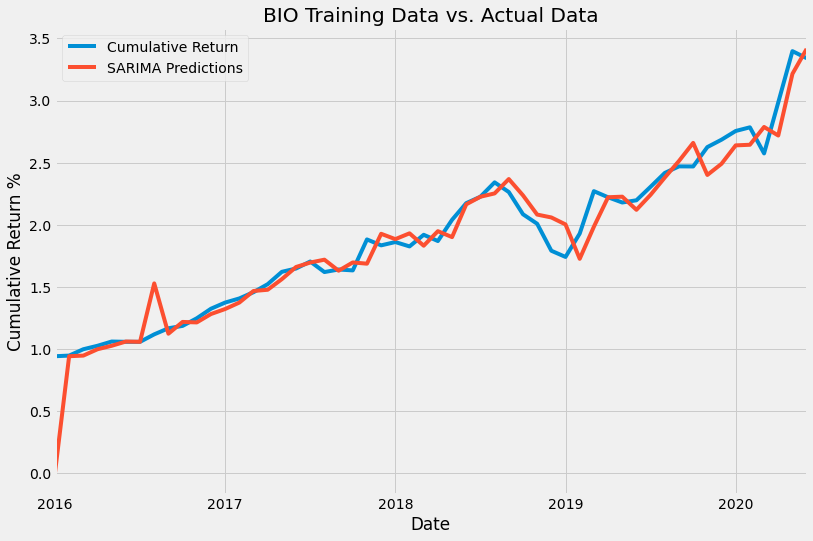

In [173]:
plot_train_pred(bio_rad, 'BIO Training Data vs. Actual Data')

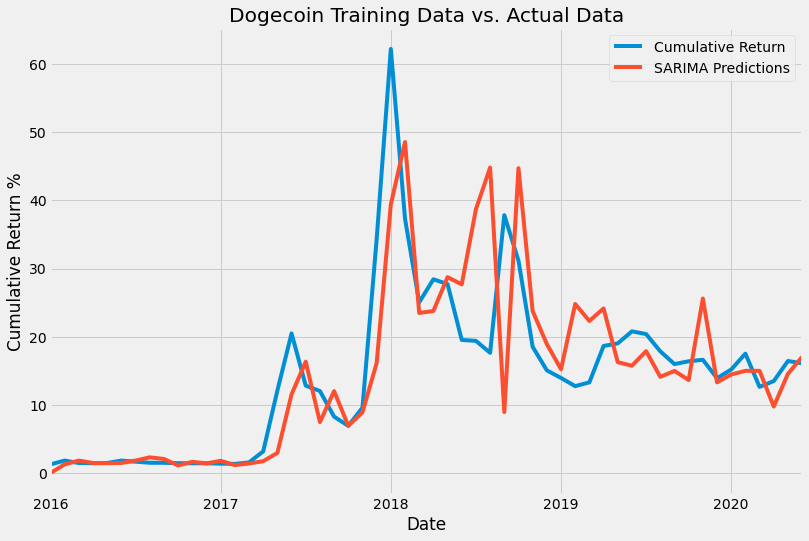

In [176]:
plot_train_pred(dogecoin, 'Dogecoin Training Data vs. Actual Data')

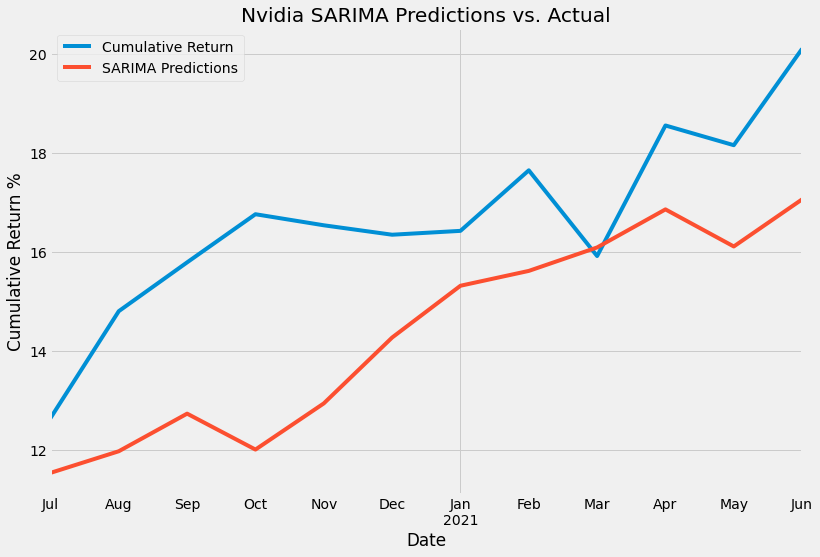

In [171]:
plot_test_pred(nvidia, 'Nvidia SARIMA Predictions vs. Actual')

In [281]:
model_rmse(nvidia)

(2.58, 16.63)

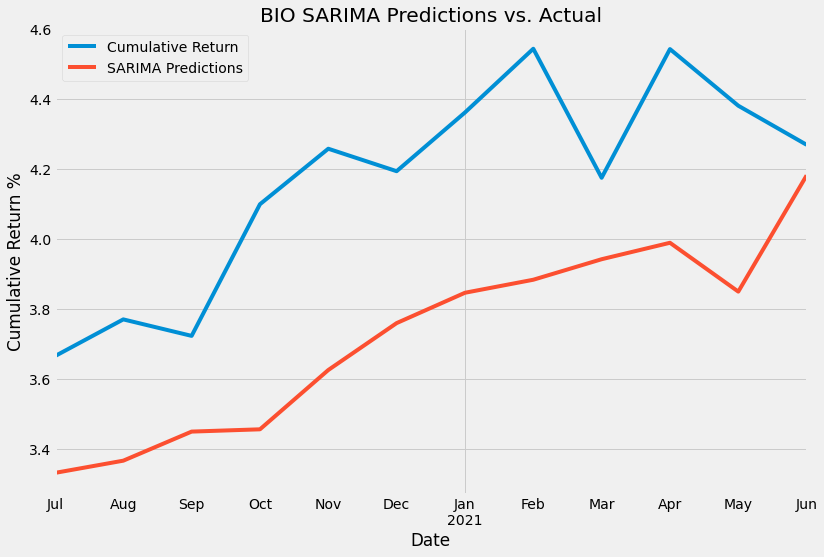

In [174]:
plot_test_pred(bio_rad, 'BIO SARIMA Predictions vs. Actual')

In [282]:
model_rmse(bio_rad)

(0.47, 4.17)

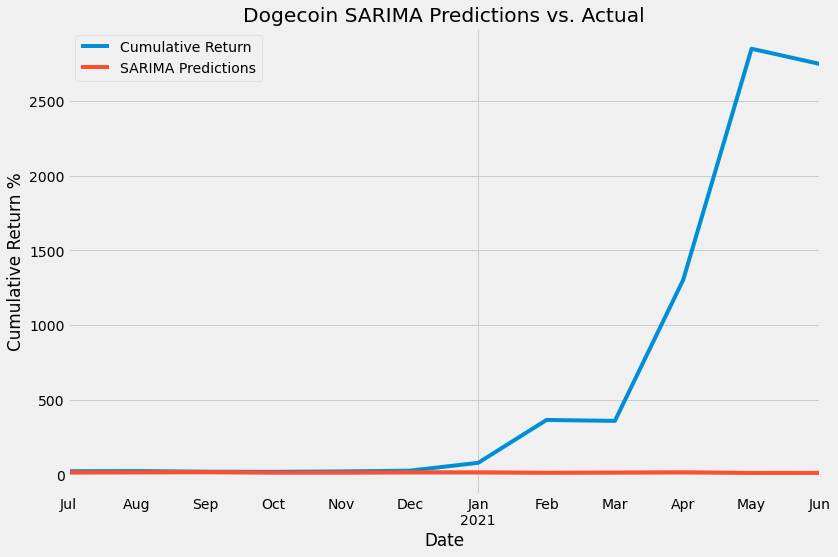

In [177]:
plot_test_pred(dogecoin, 'Dogecoin SARIMA Predictions vs. Actual')

In [280]:
model_rmse(dogecoin)

(1207.13, 652.15)

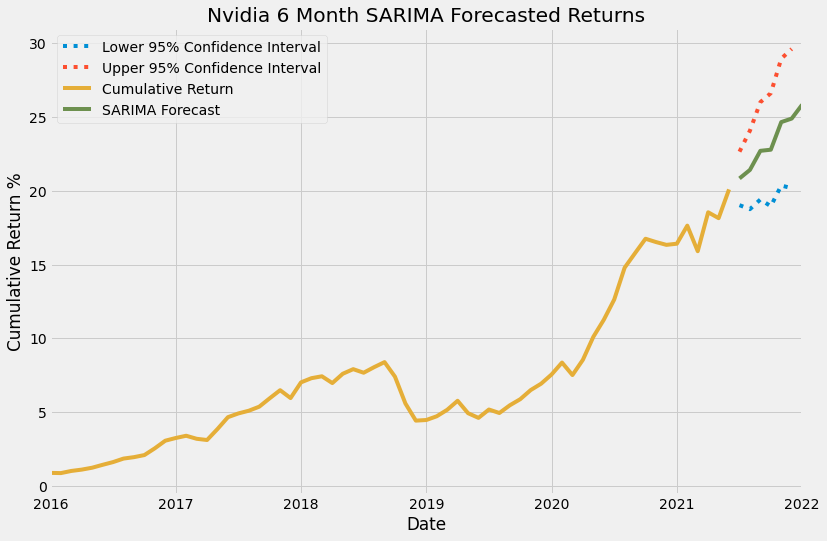

In [172]:
plot_fcast(nvidia, 'Nvidia 6 Month SARIMA Forecasted Returns')

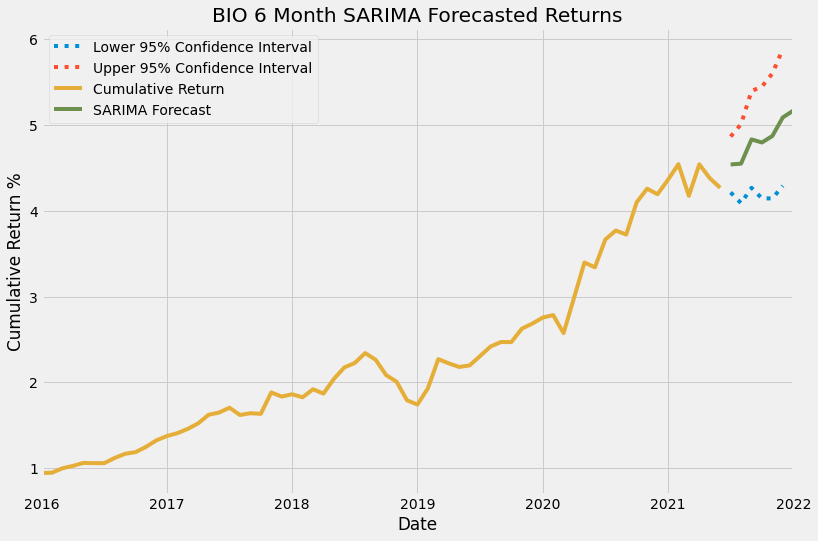

In [175]:
plot_fcast(bio_rad, 'BIO 6 Month SARIMA Forecasted Returns')

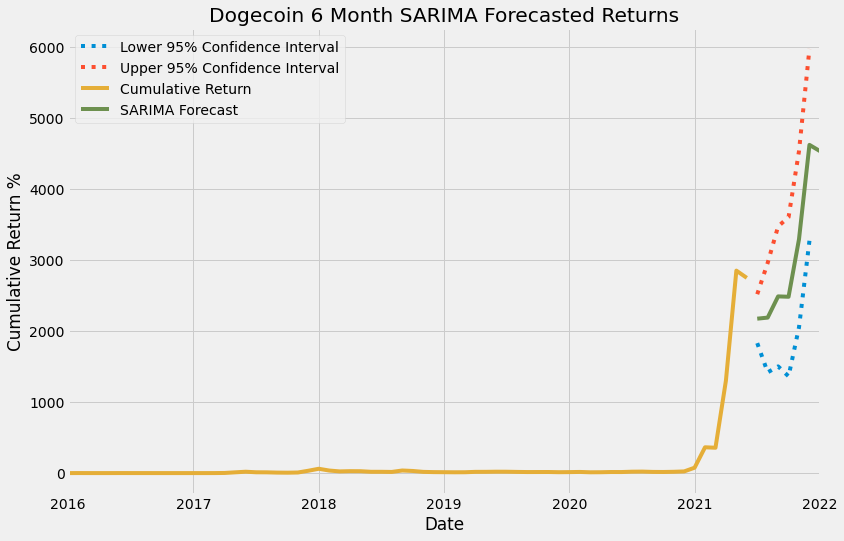

In [178]:
plot_fcast(dogecoin, 'Dogecoin 6 Month SARIMA Forecasted Returns')

### RNN Models

In [79]:
resampled = apple.resample(rule='M').mean()

In [80]:
resampled.shape

(66, 8)

In [81]:
train = resampled.iloc[:54]
test = resampled.iloc[54:]

In [82]:
train.shape

(54, 8)

In [83]:
test.shape

(12, 8)

In [84]:
scaler = MinMaxScaler()

In [85]:
scaler.fit(train[['Cumulative Return']])

MinMaxScaler()

In [86]:
scaled_train = scaler.transform(train[['Cumulative Return']])
scaled_test = scaler.transform(test[['Cumulative Return']])

In [87]:
len(scaled_train)

54

In [88]:
scaled_train[:5]

array([[0.01223802],
       [0.00307672],
       [0.03704681],
       [0.04690113],
       [0.        ]])

In [89]:
X,y = generator[0]

NameError: name 'generator' is not defined

In [ ]:
X

In [ ]:
y

In [ ]:
n_input = 12
n_features = 1

train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
model = Sequential()

model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

In [ ]:
model.fit_generator(train_generator, epochs=20)

In [ ]:
plt.plot(range(len(model.history.history['loss'])), model.history.history['loss'])

In [ ]:
first_eval_batch = scaled_train[-12:]

In [ ]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [ ]:
model.predict(first_eval_batch)

### RNN Forecast

In [ ]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [ ]:
test_predictions

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
true_predictions

In [ ]:
test['Predictions'] = true_predictions

In [ ]:
test['Cumulative Return'].plot(legend=True)
test['Predictions'].plot(legend=True)

### Facebook Prophet Models

In [203]:
from fbprophet import Prophet

### FB Prophet Tech Stock Models

In [316]:
tech_prophet_df = fb_prophet_df(tech_df)
tech_prophet_df

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

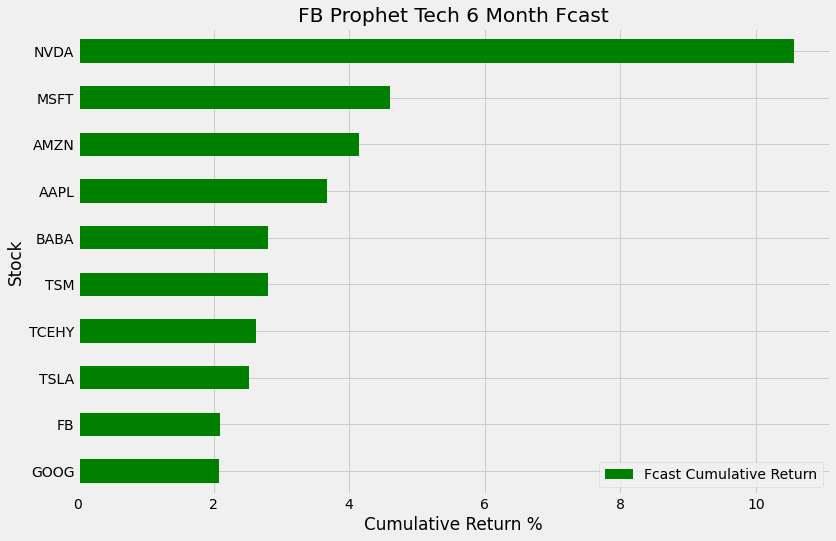

In [270]:
fb_prophet_model(tech_df, 'FB Prophet Tech 6 Month Fcast', 'g')

### FB Prophet Healthcare Stock Models

In [317]:
healthcare_prophet_df = fb_prophet_df(healthcare_df)
healthcare_prophet_df

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

,Stock,Prophet Fcast Cumulative Return
0,TDOC,7.82
1,BIO,3.85
2,UNH,2.66
3,HCA,2.46
4,PKI,1.90
5,CERN,1.21
6,ABC,0.84
7,MCK,0.77
8,CVS,0.58
9,CAH,0.52


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

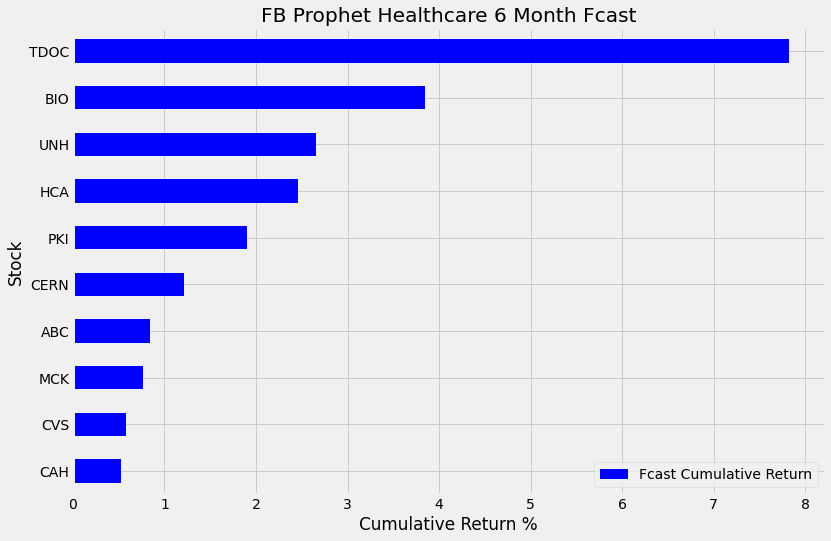

In [211]:
fb_prophet_model(healthcare_df, 'FB Prophet Healthcare 6 Month Fcast', 'b')

### FB Prophet Crypto Stock Models

In [318]:
crypto_prophet_df = fb_prophet_df(crypto_df)
crypto_prophet_df

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

,Stock,Prophet Fcast Cumulative Return
0,ETH-USD,406.62
1,XRP-USD,101.34
2,LTC-USD,38.71
3,BTC-USD,33.88
4,DOGE-USD,31.89


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

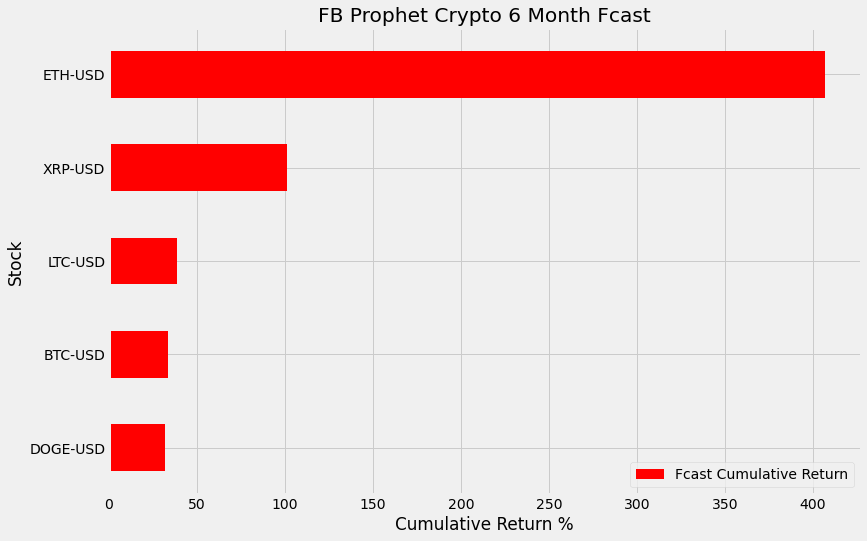

In [214]:
fb_prophet_model(crypto_df, 'FB Prophet Crypto 6 Month Fcast', 'r')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


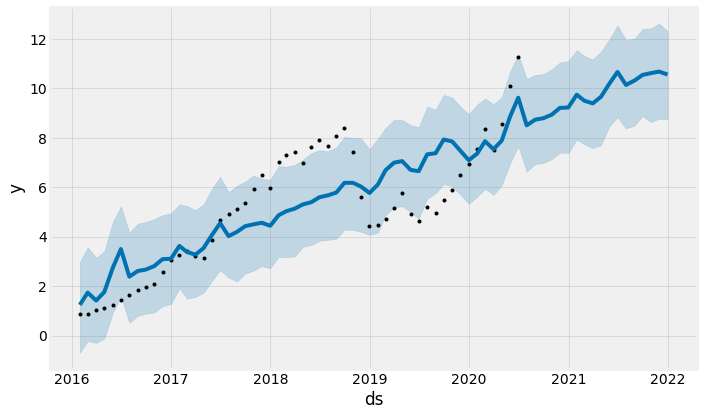

In [236]:
plot_prophet_fcast(nvidia)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


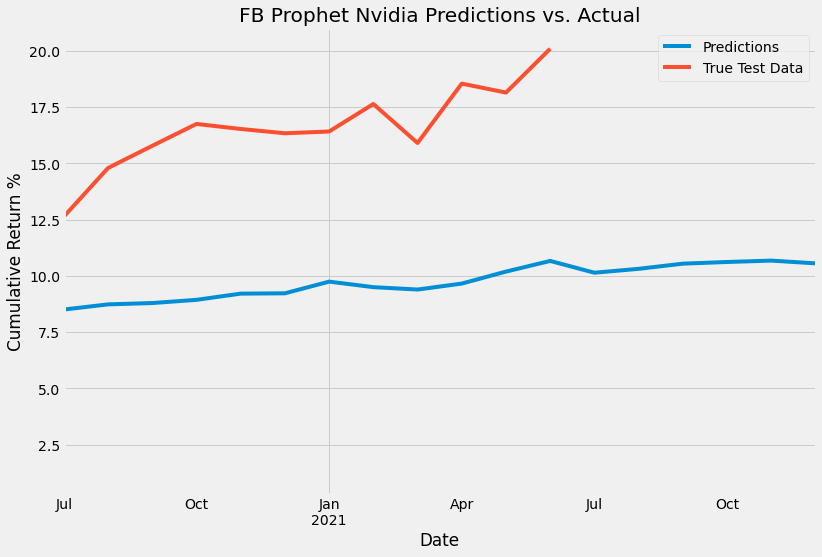

In [267]:
plot_prophet_test_fcast(nvidia, 'FB Prophet Nvidia Predictions vs. Actual')

In [264]:
prophet_rmse(nvidia)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


6.65

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


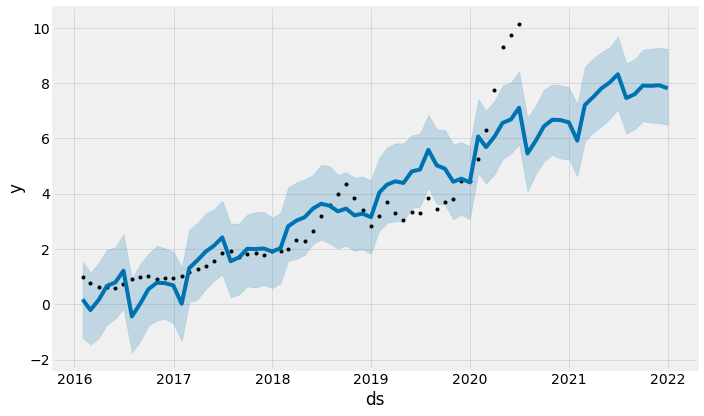

In [271]:
plot_prophet_fcast(teladoc_health)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


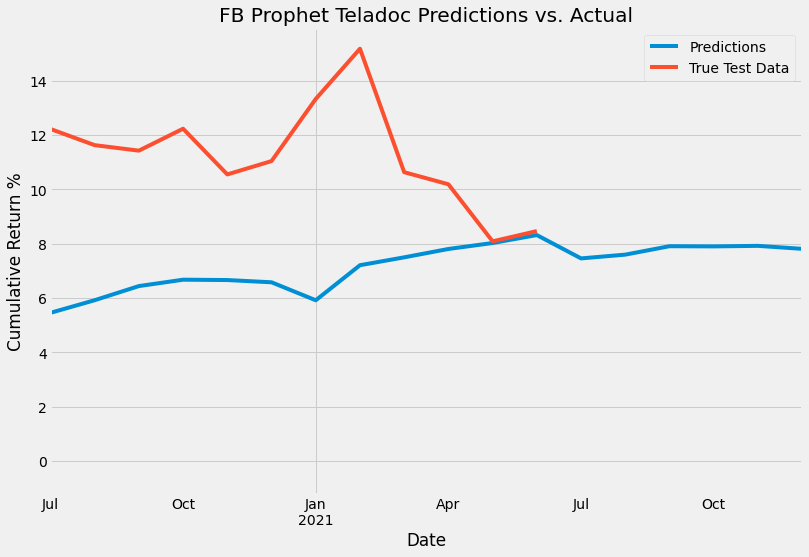

In [272]:
plot_prophet_test_fcast(teladoc_health, 'FB Prophet Teladoc Predictions vs. Actual')

In [273]:
prophet_rmse(teladoc_health)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


4.22

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


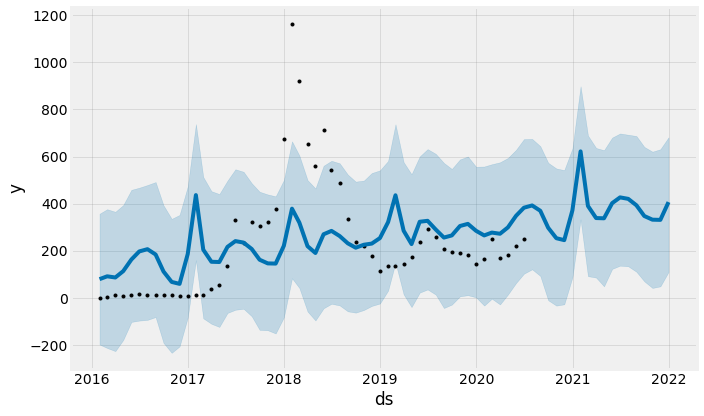

In [274]:
plot_prophet_fcast(ethereum)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


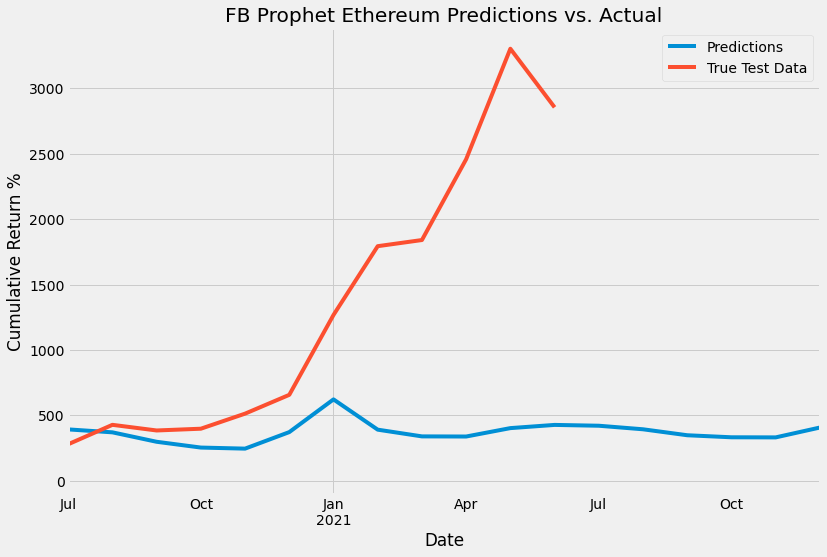

In [275]:
plot_prophet_test_fcast(ethereum, 'FB Prophet Ethereum Predictions vs. Actual')

In [276]:
prophet_rmse(ethereum)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


1426.84

In [325]:
to_concat = [tech_prophet_df, healthcare_prophet_df, crypto_prophet_df]
prophet_models_df = pd.concat(to_concat)
prophet_models_df.reset_index(drop=True, inplace=True)
prophet_models_df.head()

,Stock,Prophet Fcast Cumulative Return
0,NVDA,10.56
1,MSFT,4.60
2,AMZN,4.15
3,AAPL,3.68
4,BABA,2.81


In [233]:
rmse(predictions, test_c['y'])

1.2189373987091063

In [234]:
test_c.mean()

y    4.61268
dtype: float64

## Models Comparison

In [321]:
models_comparison = merged_df.merge(prophet_models_df, on='Stock', how='outer')
models_comparison

,Stock,Past 5 yr Cumulative Return,SARIMA 6 Month Fcast,Prophet Fcast Cumulative Return
0,NVDA,20.10,25.83,10.56
1,TSLA,13.96,19.48,2.53
2,TSM,5.36,6.98,2.80
3,AMZN,5.05,5.93,4.15
4,AAPL,4.72,5.84,3.68
5,MSFT,4.51,5.43,4.60
6,TCEHY,4.25,4.86,2.63
7,GOOG,3.28,4.13,2.08
8,FB,3.22,3.73,2.10
9,BABA,2.86,3.02,2.81


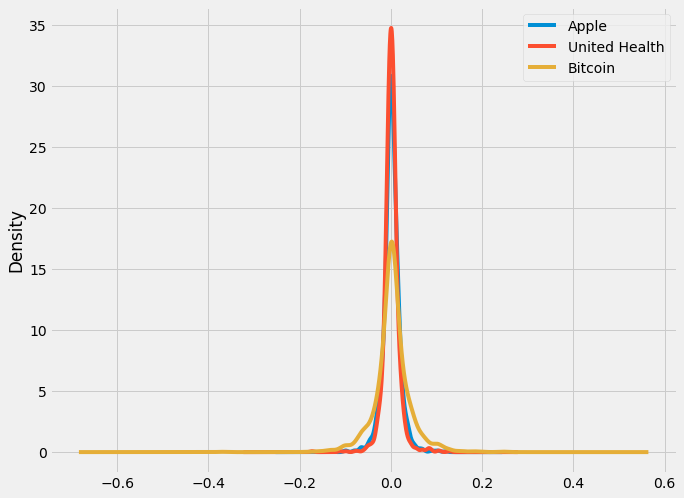

In [184]:
apple['Returns'].plot(kind='kde', label='Apple', figsize=(10,8))
united_health['Returns'].plot(kind='kde', label='United Health', figsize=(10,8))
bitcoin['Returns'].plot(kind='kde', label='Bitcoin', figsize=(10,8))
plt.legend();

## Portfolio Recommendations

## Live Dash

## Conclusion